In [13]:
# Opimize a SVR with Newuoa algorihm 
# Import all bibs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.svm import SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import rbf_kernel
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.interpolate import griddata
from sklearn.metrics import r2_score




In [14]:
# Set 70 datapoints with a testfunction
np.random.seed(1)
n = 70
lower = [-2.5,-1.5]
upper = [1.5,2.5]
x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))
f = lambda x: 20 + x[:,0]**2 + x[:,1]**2 - 10*(np.cos(2*np.pi*x[:,0]) + np.cos(2*np.pi*x[:,1]))
y = f(x)

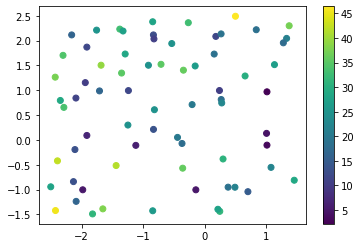

In [15]:

# Create a dataframe with the the datapoints
df = pd.DataFrame({'x.1': x[:, 0], 'x.2': x[:, 1], 'y': y})

# Create a color map using the viridis colorset
cmap = cm.viridis

# Plot the points
plt.scatter(x=df['x.1'], y=df['x.2'], c=df['y'], cmap=cmap)
plt.colorbar()
plt.show()

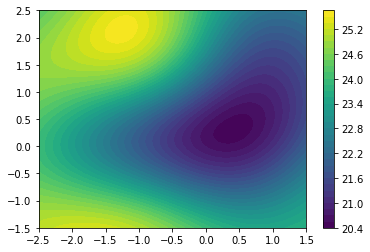

In [16]:
np.random.seed(1)

# Generate a SVR with the datapoints
model = SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1, tol=1e-3)
model.fit(x, y)

nplot_dim = 100

xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), 
                    np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])
yplot = model.predict(xplot_flat)

# Plot the SVR
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
cmap = ListedColormap(sns.color_palette("viridis", n_colors=256).as_hex())

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.show()


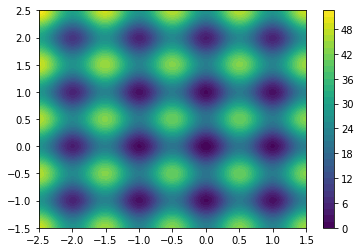

In [17]:
# Plot the testfunction 
yplot2 = f(xplot_flat)
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot2})
cmap = ListedColormap(sns.color_palette("viridis", n_colors=256).as_hex())

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.show()




Best Hyperparameters: {'gamma': -0.37398985925642503, 'C': 4.89613300395648, 'epsilon': -3.9072161034780537, 'tol': 1e-06}


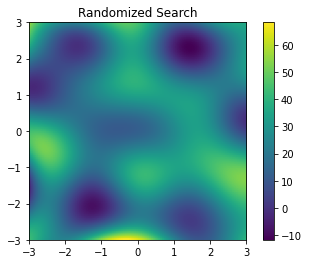

Mean Squared Error: 18.61409376568029
Fehlerwert: 0.8361113163023591


In [18]:
def uniformRandomSearch(x=None, fun=None, lower=None, upper=None, control=None, *args, **kwargs):
    con = {'funEvals': 200}  # default limit on function evaluations
    con.update(control)
    control = con
    npar = len(lower)  # number of parameters
    xtest = np.random.uniform(lower, upper, size=(control['funEvals'], npar))
    xtest[:, 3] = np.clip(xtest[:, 3], a_min=1e-6, a_max=None)  # Set lower bound for 'tol' to 1e-6
    ytest = np.array([fun(x, *args, **kwargs) for x in xtest])
    best_index = np.argmin(ytest)
    best_hyperparams = dict(zip(['gamma', 'C', 'epsilon', 'tol'], xtest[best_index, :]))
    print("Best Hyperparameters:", best_hyperparams)
    return {
        'xbest': xtest[best_index, :],
        'ybest': ytest[best_index],
        'count': xtest.shape[0]
    }


def fun(pars):
    model = SVR(kernel='rbf', gamma=10**pars[0], C=10**pars[1], epsilon=10**pars[2], tol=10**pars[3])
    model.fit(x, y)
    return np.mean((model.predict(x) - y) ** 2)  # Mean Squared Error as the evaluation metric

np.random.seed(123)
res = uniformRandomSearch(fun=fun, lower=[-6, -6, -6, -6], upper=[0, 6, 0, 0], control={'funEvals': 100})

np.random.seed(1)
lower = [-3, -3]
upper = [3, 3]

x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))
f = lambda x: 20 + x[:,0]**2 + x[:,1]**2 - 10*(np.cos(2*np.pi*x[:,0]) + np.cos(2*np.pi*x[:,1]))
y = f(x)

model = SVR(kernel='rbf', gamma=10**res['xbest'][0], C=10**res['xbest'][1], tol=10**res['xbest'][2])
model.fit(x, y)
yplot = model.predict(xplot_flat)
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
z = df['y'].values.reshape((nplot_dim, nplot_dim))

plt.imshow(z, extent=[lower[0], upper[0], lower[1], upper[1]], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Randomized Search')
plt.show()

# Berechnung des Mean Squared Error (MSE)
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)

# Berechnung des R2-Werts/Fehlerwerts
r2 = r2_score(y, y_pred)

# Ausgabe der Werte
print("Mean Squared Error:", mse)
print("Fehlerwert:", r2)

